In [3]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import time

# 9个点预测一个点
# 主要问题在于维度匹配，这是一个many-to-one的问题，需要取最后一个时刻的ht而不是整个output
# 如果输入了h0，c0，还要使用GPU训练，要确保输入之后h0和c0位于GPU中

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputsize = 1
batchsize = 1024
outputsize = 1
seq_length = 9

h_size = 16
layers = 1
lrate = 0.001
bidir = False
epoch = 200

# 读取txt文件
def readtxt(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f.readlines():
            line = line.strip("\n")
            line = line.split()
            data.append(line)
    data = np.array(data, dtype="float32")
    # print(data.shape[0])
    return data


# 定义数据集
class MyDataset(Dataset):
    def __init__(self, input, output):
        self.data_input = torch.from_numpy(input)
        self.data_output = torch.from_numpy(output)
        self.len = self.data_output.shape[0]

    def __getitem__(self, idx):
        return self.data_input[idx], self.data_output[idx]

    def __len__(self):
        return self.len

# 定义LSTM网络
class Mylstm(nn.Module):
    """
    seq:sequence length
        input_size:feature size
        hidden_size:hidden layer size
        output_size:output size(after linear layer)
        h0:initial h
        c0:initial c
        ht:every layer last h
        out:h of every time and last layer in the sequence
    """
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_layers=1, batch_first=False, dropout=0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=batch_first, dropout=dropout)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.layernorm = nn.LayerNorm([inputsize])
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input:[seq, batch_size, input_size]
        # h_0 = h0.to(device)
        # c_0 = c0.to(device)
        output, (ht, ct) = self.lstm(input)
        # output: [seq, batch_size, hidden_size]
        seq, bs, h = output.shape
        # 取出最后一个时刻的预测值hidden_t
        hidden_t = torch.cat([ht[-1]], dim=1)
        # 过全连接层
        out = self.fc(hidden_t)
        # 标准化
        # out = self.layernorm(out)

        return out, (ht, ct)

def Normalize(data):
    data_mean = torch.mean(data)
    data_std = torch.std(data)
    data_norm = (data - data_mean) / data_std
    return data_norm


# 原始数据
train_input = np.array(readtxt("training_data_input.txt"))
test_input = np.array(readtxt("testing_data_input.txt"))
data_input = np.concatenate((train_input, test_input), axis=0)
data_input = data_input.reshape(data_input.shape[0] * data_input.shape[1], -1)

input_seq = np.zeros(0, dtype='float32')
output_seq = np.zeros(0, dtype='float32')
# 滑动窗口处理
for i in range(data_input.shape[0] - 10):
    input_seq = np.append(input_seq, data_input[i:i + 9])
    output_seq = np.append(output_seq, data_input[i + 10])
input_seq = input_seq.reshape(-1, 9)
output_seq = output_seq.reshape(-1, 1)

train_ratio = 0.5
train_len = int(train_ratio * input_seq.shape[0])
train_input_seq = input_seq[:train_len]
train_output_seq = output_seq[:train_len]
test_input_seq = input_seq[train_len:]
test_output_seq = output_seq[train_len:]

# 数据集导入
train_dataset = MyDataset(train_input_seq, train_output_seq)
test_dataset = MyDataset(test_input_seq, test_output_seq)
# 标准化
data_input_norm = torch.cat([train_dataset.data_input, train_dataset.data_input], dim=0)
data_output_norm = torch.cat([train_dataset.data_output, test_dataset.data_output], dim=0)
data_input_norm = Normalize(data_input_norm)
data_output_norm = Normalize(data_output_norm)
train_dataset.data_input = data_input_norm[:train_len]
train_dataset.data_output = data_output_norm[:train_len]
test_dataset.data_input = data_input_norm[train_len:]
test_dataset.data_output = data_output_norm[train_len:]

# Dataloader初始化
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=False, num_workers=0, drop_last=False,
                          pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False, num_workers=0, drop_last=False,
                         pin_memory=True)
# 模型初始化
model = Mylstm(input_size=inputsize, hidden_size=h_size, output_size=outputsize, num_layers=layers)
model = model.to(device)

criterion = nn.MSELoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lrate)
# 指数学习率衰减
explr = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
losses = []

# if bidir == False:
#     h0 = torch.zeros([1 * layers, batchsize, h_size])
#     c0 = torch.zeros([1 * layers, batchsize, h_size])
# else:
#     h0 = torch.zeros([2 * layers, batchsize, h_size])
#     c0 = torch.zeros([2 * layers, batchsize, h_size])
writer = SummaryWriter("logs")
model = model.train()
for iter in range(epoch):
    # start_time = time.perf_counter()
    loss = torch.zeros(0)
    # 遍历数据集
    for data in train_loader:
        data_in, data_out = data
        # input -> [seq, batch_size, input_size]，匹配输入维度
        data_in = data_in.view(data_in.shape[1], data_in.shape[0], inputsize)
        # 存入GPU
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        # 这里的output是最后一个时刻的ht
        output, (ht, ct) = model(data_in)
        # 反向传播
        loss = criterion(output, data_out)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        # explr.step()

    # end_time = time.perf_counter()
    # print(str(end_time - start_time))
    losses.append(loss.item())
    if iter % 50 == 0:
        print("Iteration: {}  Loss: {:.6f}".format(iter, loss.item()))
        writer.add_scalar("loss", loss.item(), iter)
writer.close()

# 保存模型
torch.save(model.state_dict(), "model0224.pth")

2023-02-24 16:51:35.255986: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Iteration: 0  Loss: 0.964573
Iteration: 50  Loss: 0.003411
Iteration: 100  Loss: 0.004438
Iteration: 150  Loss: 0.004248


In [4]:
# 预测，切换回CPU
model = model.eval().cpu()
real_output = torch.cat([train_dataset.data_output, test_dataset.data_output], dim=0)

pred_input = torch.cat([train_dataset.data_input, test_dataset.data_input], dim=0)
predictions = np.zeros(0)

for i in range(pred_input.shape[0]):
    with torch.no_grad():
        pred_train_input = pred_input[i].view(9, 1, 1)
        pred, _ = model(pred_train_input)
        predictions = np.append(predictions, pred.numpy())

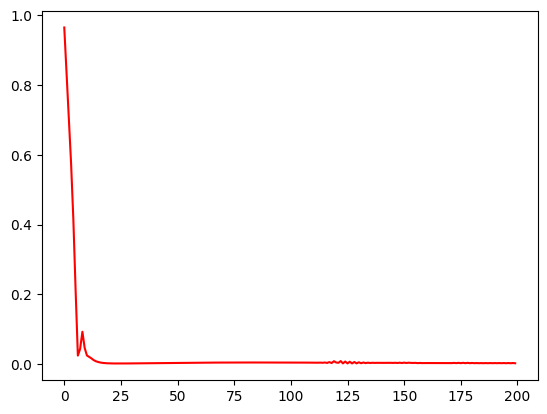

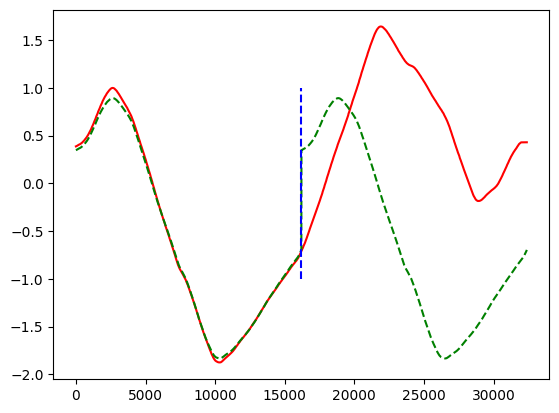

In [5]:
plt.subplots(1, 1)
plt.plot(losses, "r")
plt.subplots(1, 1)

plt.plot(real_output.numpy(), "r")
plt.plot(predictions, "g--")
plt.plot((train_len, train_len), (-1, 1), "b--")
plt.savefig('test1.png', format='png', dpi=200)
plt.show()